<a href="https://colab.research.google.com/github/nagamamo/international_finance/blob/main/8_purchasing_power_parity_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**8　購買力平価モデルによる為替レートの予測**

8.1 汎用ライブラリの読み込み

　本例では、米国労働省および日本統計局の物価月次データを用い、購買力平価モデルの理論実装例を示します。まず汎用ライブラリとして、pandas、numpy、datetime、matplotlibを読み込みます。

In [1]:
#[1]汎用ライブラリの読み込み
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

8.2　単位根検定ライブラリの読み込み

　購買力平価モデルを用いる際にも、単位根検定を行った上で、実装しなければなりません。単位根検定を実施するためのライブラリは下記をインポートします。

In [14]:
#[2]時系列データ検定ライブラリの読み込み
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #ADF検定用ライブラリ

8.3　統計処理用ライブラリの読み込み

　OLS推計用のライブラリをインポートします。本例では、sklearnを用いて機械学習による実証モデルの性能評価を行い、予測値を算出します。

In [22]:
#[3]機械学習用ライブラリの読み込み
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #学習・テストデータ分割のライブラリ

8.4　日米インフレ率・ドル円レート月次データの取得

　　外国為替レート、日米消費者物価指数の1972年1月から2025年11月までのデータを取得します。本データの場合は、日時情報”Date”はデータとして利用しませんので、datetimeへ変換してインデックスとして利用します。これによりグラフ作成の際に横軸目盛が自動調整され、目盛文字が重なることがありません。

In [ ]:
#[4]データの取得
url = "https://github.com/nagamamo/data/blob/main/8_purchasing_power_parity.csv?raw=true"#Git-hubからCSVデータの入手
data = pd.read_csv(url)#データフレームの作成
data["Date"] = pd.to_datetime(data["Date"]) #日時をインデックスの変換のためdatetimeへ変換
US_Japan = data.set_index("Date")#日時をインデックスへ変換
US_Japan.head()

8.5　分析対象国データの抽出

　取得したデータから、ドル円レートの前月比（d_Yen）、日米インフレ率格差（d_P）を算出してpandasデータフレームにそれぞれの新変数列を追加します。この説明変数が、購買力平価要因を説明します。重ねて述べるように、sklearnではデータの入出力はnumpy配列を前提としていますので、pandasデータフレームのデータを「.value」により変換し、これをYとXとします。

In [ ]:
#[5]採用変数の算出と定義
US_Japan['d_P']=US_Japan['USA_CPI']-US_Japan['Japan_CPI'] #日米インフレ率格差の算出
US_Japan['d_Yen']=US_Japan['yen_dollar'].pct_change()*100 #為替レート前月比の算出
US_Japan=US_Japan.dropna()#欠損値の除去
Y=US_Japan['d_Yen'].values #被説明変数の定義と配列変更
X=US_Japan[['d_P']].values #説明変数の定義と配列変更
US_Japan.head()

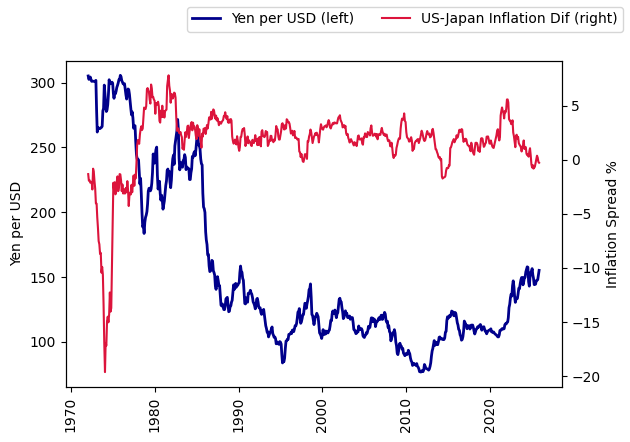

In [18]:
#[6]データの可視化
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(US_Japan['yen_dollar'], lw=2, color="darkblue",label="Yen per USD (left)")
ax2.plot(US_Japan['d_P'], c="crimson",label="US-Japan Inflation Dif (right)")
fig.autofmt_xdate(rotation=90, ha="center")
plt.ylabel('Yen per USD')
ax1.set_ylabel('Yen per USD')
ax2.set_ylabel('Inflation Spread %')
fig.legend(ncol=2)
plt.show()

8.6　推計

　次にデータを学習データ(X_train、Y_train)とテストデータ（X_test、Y_test）に分割し、学習データに購買力平価モデルをフィッティングします。[6]１行目のコードは、学習データとテストデータを、ランダムに70％：30％に分割することを指示しています。2行目のコードで推計に最小二乗法を採用し、3行目において学習データを用いてフィッティングを行います。4行目と5行目は、それぞれ学習データとテストデータを用いた為替レート（変化率）の予測値を算出します。この学習データとテストデータの予測値を比較することで、この実証モデルの性能を評価します。

In [19]:
#[6]購買力平価モデルの推計
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)#学習データとテストデータの分割
model=LinearRegression(fit_intercept=True,copy_X=True,n_jobs=1,positive=False)#推計方法の定義
model.fit(X_train,Y_train)#フィッティング
Y_train_pred=model.predict(X_train)#学習データによる予測値の算出
Y_test_pred=model.predict(X_test)#テストデータによる予測値の算出

推計結果を出力します。

In [ ]:
#[7]推計結果の表示
print('d_P coef: %.4f' % model.coef_[0])#係数値
print('R2: %.4f' %model.score(X_train,Y_train))#決定係数

　最後のセルは、将来のドル円レートを予測するコードです。それぞれlast（直近の米日金利差）、add_spread（未来の金利拡大もしくは縮小幅）、add_CPI（未来の米日インフレ率格差）を入力すれば、その「未来」時点でのドル円レートが計算されます。直近の値は、任意に与えても差し障りありません。米連邦準備制度理事会もしくは日本銀行の金融引き締めによる長期金利差の変化の為替レートへの影響のみを確認したい場合は、add_CPI=0とすると、政策効果のみを演算できます。

In [ ]:
#[8]ドル円レートの予測
lastP=US_Japan.d_P[-1] #標本データ直近の米日インフレ率格差
add_CPI=-1.0 #インフレ率格差拡大幅
spot=155.54 #直近ドル円レート
senario_P=lastP+add_CPI
a=model.predict([[senario_P]])
spot*(1+a/100)

8.7　単位根検定

　時系列データを用いる場合、時間の経過とともにデータの平均値や分散が変化する単位根を持つか否かを確認した上で、分析を行う必要があります。その理由は、採用するデータがもし時間変化とともに確率分布が変化する非定常過程なのであれば、変数間に誤った関係が存在することを支持してしまう懸念があるためです。この点、データサイエンスでは、例えばある時点tとそれ以前のt-1もしくは更に過去のデータとの関係を示す自己回帰モデルを推計することで、時系列データの定常性（非定常性）を統計的に確認します。これが単位根検定と呼ばれる検定方法です。本例ではstatmodelsの拡張版Dickey=Fuller検定（ADF検定）によりデータの定常性を検定します。本例では、自己回帰モデルにトレンドは含めず、定数項のみと設定しています。
単位根検定の結果は、左から順にADF検定量、p値、検定に用いたラグ数、標本数、1%、5%、10%有意水準を示しています。

In [ ]:
#[9]時系列データの単位根検定
#sm.tsa.stattools.adfuller(Y, regression='c') #為替レート変化率の単位根検定
sm.tsa.stattools.adfuller(X, regression='c') #米日インフレ率格差の単位根検定

　データの定常性が確認されれば、データ数と説明変数の配列を念のため確認しておきます。

In [21]:
#[10]データ数と配列の確認
ndarrayX = np.array(X)
ndarrayY = np.array(Y)
print("ndarrayX.shape:", ndarrayX.shape)
print("ndarrayY.shape:", ndarrayY.shape)

ndarrayX.shape: (646, 1)
ndarrayY.shape: (646,)
